In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/trades.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/__init__.py
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv
/kaggle/input/jpx-tokyo-stock-

# 1. Data Processing

The majority of the code follows the provided template code in the [Competition's Train Demo Notebook](https://www.kaggle.com/code/smeitoma/train-demo/notebook), but this notebook uses an **LSTM model** to make stock price predictions instead of the Demo's LGBM model.

The following functions are used to adjust the close prices in the raw stock price data.

We import the code necessary for the LSTM Model.

We load the data, adjust closing prices, and view the resulting data.

In [2]:
from decimal import ROUND_HALF_UP, Decimal

def adjust_price(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)

    price.set_index("Date", inplace=True)
    return price

In [3]:
# Load stock price data
df_price = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv")
# df_supp =  pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv")

In [4]:
df_price = adjust_price(df_price)
# df_supp = adjust_price(df_supp)
df_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2332531 entries, 2017-01-04 to 2021-12-03
Data columns (total 13 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   RowId                       object 
 1   SecuritiesCode              int64  
 2   Open                        float64
 3   High                        float64
 4   Low                         float64
 5   Close                       float64
 6   Volume                      int64  
 7   AdjustmentFactor            float64
 8   ExpectedDividend            float64
 9   SupervisionFlag             bool   
 10  Target                      float64
 11  CumulativeAdjustmentFactor  float64
 12  AdjustedClose               float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 233.6+ MB


In [5]:
display(df_price.head(2))
display(df_price.tail(2))

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,CumulativeAdjustmentFactor,AdjustedClose
Date,,,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.00073,1.0,2742.0
2017-01-05,20170105_1301,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.00292,1.0,2738.0


,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,CumulativeAdjustmentFactor,AdjustedClose
Date,,,,,,,,,,,,,
2021-12-02,20211202_9997,9997,681.0,692.0,680.0,684.0,342900,1.0,NaN,False,0.014368,1.0,684.0
2021-12-03,20211203_9997,9997,690.0,711.0,686.0,696.0,381100,1.0,NaN,False,0.018414,1.0,696.0


The following function represents **Feature Engineering**, and we can use this to set features for the stock price data.

In [6]:
def get_features_for_predict(price, code):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
        code (int)  : A local code for a listed company
    Returns:
        feature DataFrame (pd.DataFrame)
    """
    close_col = "AdjustedClose"
    feats = price.loc[price["SecuritiesCode"] == code, ["SecuritiesCode",
      close_col, "ExpectedDividend", "High", "Low", "Open", "Close"]].copy()

    # single case
    feats["return_1day"] = feats[close_col].pct_change(1)

    # ExpectedDividend
    feats["ExpectedDividend"] = feats["ExpectedDividend"].mask(feats["ExpectedDividend"] > 0, 1)

    # Amplitude
    feats["Amplitude"] = feats["High"] - feats["Low"]

    # Open to Close
    feats["OpentoClose"] = feats["Open"] - feats["Close"]

    # 52 Week High
    High52 = feats['AdjustedClose']/feats['High'].rolling(250).max()
    High52.rename('High52',inplace = True)
    feats = feats.merge(High52,left_index = True,right_index = True, how = 'left')

    # MACD
    feats["MACD"] = feats[close_col].ewm(span=12, adjust=False).mean() - feats[close_col].ewm(span=26, adjust=False).mean()

    for period in [5, 10, 20, 40, 60]:

      # calculate return using AdjustedClose
      feats["return_{}day".format(period)] = feats[close_col].pct_change(period)

      # volatility
      feats["volatility_{}day".format(period)] = np.log(feats[close_col]).diff().rolling(period).std()

      # moving average
      feats["MA_{}day".format(period)] = feats[close_col].rolling(period).mean()

      # exponential moving average
      feats["EMA_{}day".format(period)] = feats[close_col].ewm(span=period, adjust=False).mean()

      # RSI
      C_Diff = feats['AdjustedClose'] - feats['AdjustedClose'].shift(1)
      U = C_Diff.apply(lambda series: series if series > 0 else 0)
      D = C_Diff.apply(lambda series: -series if series < 0 else 0)
      EMA_U = U.ewm(span = period, adjust = False).mean()
      EMA_D = D.ewm(span = period, adjust = False).mean()
      RSI = EMA_U/(EMA_U+EMA_D) * 100
      RSI.rename('RSI_{}day'.format(period),inplace = True)
      feats = feats.merge(RSI,left_index = True,right_index = True,how = 'left')

      # MACD
      feats["MACD_{}day".format(period)] = feats[close_col].ewm(span=period,
        adjust=False).mean() - feats[close_col].ewm(span=2*period, adjust=False).mean()

      # BIAS
      BIAS = feats['AdjustedClose'].rolling(period).mean()
      BIAS = (feats['AdjustedClose'] - BIAS)/BIAS
      BIAS.rename('BIAS_{}day'.format(period),inplace = True)
      feats = feats.merge(BIAS,left_index = True,right_index = True, how = 'left')

    # filling data for nan and inf
    feats = feats.fillna(0)
    feats = feats.replace([np.inf, -np.inf], 0)
    # drop AdjustedClose column
    feats = feats.drop([close_col], axis=1)

    return feats

In [7]:
# fetch prediction target SecuritiesCodes
# There are 2000 codes
codes = sorted(df_price["SecuritiesCode"].unique())
len(codes)

2000

In [8]:
from tqdm import tqdm
# generate the features for prediction
buff = []
for code in tqdm(codes):
    feat = get_features_for_predict(df_price, code)
    buff.append(feat)
feature = pd.concat(buff)

100%|██████████| 2000/2000 [03:17<00:00, 10.13it/s]


In [9]:
display(feature.head(2))
display(feature.tail(2))

,SecuritiesCode,ExpectedDividend,High,Low,Open,Close,return_1day,Amplitude,OpentoClose,High52,...,RSI_40day,MACD_40day,BIAS_40day,return_60day,volatility_60day,MA_60day,EMA_60day,RSI_60day,MACD_60day,BIAS_60day
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,1301,0.0,2755.0,2730.0,2734.0,2742.0,0.000000,25.0,-8.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,2742.000000,0.0,0.000000,0.0
2017-01-05,1301,0.0,2747.0,2735.0,2743.0,2738.0,-0.001459,12.0,5.0,0.0,...,0.0,-0.096357,0.0,0.0,0.0,0.0,2741.868852,0.0,-0.065032,0.0


,SecuritiesCode,ExpectedDividend,High,Low,Open,Close,return_1day,Amplitude,OpentoClose,High52,...,RSI_40day,MACD_40day,BIAS_40day,return_60day,volatility_60day,MA_60day,EMA_60day,RSI_60day,MACD_60day,BIAS_60day
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-02,9997,0.0,692.0,680.0,681.0,684.0,-0.001460,12.0,-3.0,0.506292,...,28.820208,-54.122108,-0.111284,-0.206497,0.013802,799.333333,785.312539,31.289117,-67.940654,-0.144287
2021-12-03,9997,0.0,711.0,686.0,690.0,696.0,0.017544,25.0,-6.0,0.515174,...,33.455413,-54.254605,-0.092006,-0.195376,0.014042,796.516667,782.384259,34.205419,-68.269707,-0.126195


In [10]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2332531 entries, 2017-01-04 to 2021-12-03
Data columns (total 46 columns):
 #   Column            Dtype  
---  ------            -----  
 0   SecuritiesCode    int64  
 1   ExpectedDividend  float64
 2   High              float64
 3   Low               float64
 4   Open              float64
 5   Close             float64
 6   return_1day       float64
 7   Amplitude         float64
 8   OpentoClose       float64
 9   High52            float64
 10  MACD              float64
 11  return_5day       float64
 12  volatility_5day   float64
 13  MA_5day           float64
 14  EMA_5day          float64
 15  RSI_5day          float64
 16  MACD_5day         float64
 17  BIAS_5day         float64
 18  return_10day      float64
 19  volatility_10day  float64
 20  MA_10day          float64
 21  EMA_10day         float64
 22  RSI_10day         float64
 23  MACD_10day        float64
 24  BIAS_10day        float64
 25  return_20day      float64
 26 

We define a function to obtain labels for the data.

In [11]:
def get_label(price, code):
    """ Labelizer
    Args:
        price (pd.DataFrame): dataframe of stock_price.csv
        code (int): Local Code in the universe
    Returns:
        df (pd.DataFrame): label data
    """
    df = price.loc[price["SecuritiesCode"] == code].copy()
    df.loc[:, "label"] = df["Target"]

    return df.loc[:, ["SecuritiesCode", "label"]]

# split data into TRAIN and TEST
TRAIN_END = "2019-12-31"
# We put a week gap between TRAIN_END and TEST_START
# to avoid leakage of test data information from label
TEST_START = "2020-01-06"


def get_features_and_label(price, codes, features):
    """
    Args:
        price (pd.DataFrame): loaded price data
        codes  (array) : target codes
        feature (pd.DataFrame): features
    Returns:
        train_X (pd.DataFrame): training data
        train_y (pd.DataFrame): label for train_X
        test_X (pd.DataFrame): test data
        test_y (pd.DataFrame): label for test_X
    """
    # to store splited data
    trains_X, tests_X = [], []
    trains_y, tests_y = [], []

    # generate feature one by one
    for code in tqdm(codes):

        feats = features[features["SecuritiesCode"] == code].dropna()
        labels = get_label(price, code).dropna()
        
        if feats.shape[0] > 0 and labels.shape[0] > 0:
            # align label and feature indexes
            labels = labels.loc[labels.index.isin(feats.index)]
            feats = feats.loc[feats.index.isin(labels.index)]
            
            assert (labels.loc[:, "SecuritiesCode"] == feats.loc[:, "SecuritiesCode"]).all()
            labels = labels.loc[:, "label"]

            # split data into TRAIN and TEST
            _train_X = feats[: TRAIN_END]
            _test_X = feats[TEST_START:]

            _train_y = labels[: TRAIN_END]
            _test_y = labels[TEST_START:]
            
            assert len(_train_X) == len(_train_y)
            assert len(_test_X) == len(_test_y)

            # store features
            trains_X.append(_train_X)
            tests_X.append(_test_X)
            # store labels
            trains_y.append(_train_y)
            tests_y.append(_test_y)
            
    # combine features for each codes
    train_X = pd.concat(trains_X)
    test_X = pd.concat(tests_X)
    # combine label for each codes
    train_y = pd.concat(trains_y)
    test_y = pd.concat(tests_y)

    return train_X, train_y, test_X, test_y

We split the data into **Train** and **Test** sets. This can also be updated to obtain **Validation** sets later on.

In [12]:
# generate feature/label
train_X, train_y, test_X, test_y = get_features_and_label(
    df_price, codes, feature
)

100%|██████████| 2000/2000 [00:25<00:00, 78.84it/s]


In [13]:
train_X.loc[:, 'Target'] = train_y
test_X.loc[:, 'Target'] = test_y
train_X.reset_index(inplace = True)
test_X.reset_index(inplace = True)
df_price.reset_index(inplace = True)
train_X = df_price[["Date", "SecuritiesCode"]].merge(train_X, left_on = ['Date', 'SecuritiesCode'],right_on = ['Date', 'SecuritiesCode'], how = 'right')
test_X = df_price[["Date", "SecuritiesCode"]].merge(test_X, left_on = ['Date', 'SecuritiesCode'],right_on = ['Date', 'SecuritiesCode'], how = 'right')
train_X.dropna(inplace = True)
test_X.dropna(inplace = True)

train_y = train_X['Target']
test_y = test_X['Target']
train_X.drop("Target", axis = 1, inplace = True);
test_X.drop("Target", axis = 1, inplace = True);

print("train_X has shape", train_X.shape)
print("train_y has shape", train_y.shape)
print("test_X has shape", test_X.shape)
print("test_y has shape", test_y.shape)

train_X.set_index('Date', inplace = True)
test_X.set_index('Date', inplace = True)

old_test_X = test_X
old_train_X = train_X
# feat_cols = list(range(1, 4))
# train_X = train_X.iloc[:, feat_cols]
# test_X = test_X.iloc[:, feat_cols]

train_X has shape (1399453, 47)
train_y has shape (1399453,)
test_X has shape (932840, 47)
test_y has shape (932840,)


In [14]:
train_X.columns

Index(['SecuritiesCode', 'ExpectedDividend', 'High', 'Low', 'Open', 'Close',
       'return_1day', 'Amplitude', 'OpentoClose', 'High52', 'MACD',
       'return_5day', 'volatility_5day', 'MA_5day', 'EMA_5day', 'RSI_5day',
       'MACD_5day', 'BIAS_5day', 'return_10day', 'volatility_10day',
       'MA_10day', 'EMA_10day', 'RSI_10day', 'MACD_10day', 'BIAS_10day',
       'return_20day', 'volatility_20day', 'MA_20day', 'EMA_20day',
       'RSI_20day', 'MACD_20day', 'BIAS_20day', 'return_40day',
       'volatility_40day', 'MA_40day', 'EMA_40day', 'RSI_40day', 'MACD_40day',
       'BIAS_40day', 'return_60day', 'volatility_60day', 'MA_60day',
       'EMA_60day', 'RSI_60day', 'MACD_60day', 'BIAS_60day'],
      dtype='object')

In [15]:
X_train = train_X.values
X_test = test_X.values
y_train = train_y.values
y_test = test_y.values

In [16]:
print("train_X has shape", X_train.shape)
print("train_y has shape", y_train.shape)
print("test_X has shape", X_test.shape)
print("test_y has shape", y_test.shape)

train_X has shape (1399453, 46)
train_y has shape (1399453,)
test_X has shape (932840, 46)
test_y has shape (932840,)


# 2. Training

We create the model; this is where we can design the neural network's structure and parameters.

In [17]:
# import matplotlib.pyplot as plt

# for i in range(X_train.shape[1]):
#     plt.scatter(X_train[:, i], train_y)
#     plt.xlabel(train_X.columns[i])
#     plt.ylabel('y_train')
#     plt.show()

In [18]:
from sklearn.linear_model import LassoCV, Lasso, LinearRegression

reg_params = 10**(np.linspace(-8, -0.5, 100))
num_params = len(reg_params)

model_lasso = LassoCV(n_alphas = num_params, alphas = reg_params,
                      cv = 5, random_state = 0).fit(X_train, y_train)
model_LR = LinearRegression().fit(X_train, y_train)

In [19]:
from sklearn.metrics import mean_squared_error

best_lasso_alpha = model_lasso.alpha_
lasso_train_r2 = model_lasso.score(X_train, y_train)
lasso_train_pred = model_lasso.predict(X_train)
lasso_test_r2= model_lasso.score(X_test, y_test)
lasso_test_pred = model_lasso.predict(X_test)

train_lasso_rmse = np.sqrt(mean_squared_error(y_train, lasso_train_pred))
test_lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_test_pred))

In [20]:
print(f"Lasso training R^2 for, {best_lasso_alpha:0.2e}, is: {lasso_train_r2:0.2e}")
print(f"Lasso training RMSE for, {best_lasso_alpha:0.2e}, is: {train_lasso_rmse:0.2e}")
print(f"Lasso test R^2 for, {best_lasso_alpha:0.2e}, is: {lasso_test_r2:0.2e}")
print(f"Lasso test RMSE for, {best_lasso_alpha:0.2e}, is: {test_lasso_rmse:0.2e}")

Lasso training R^2 for, 9.66e-08, is: 3.00e-03
Lasso training RMSE for, 9.66e-08, is: 2.16e-02
Lasso test R^2 for, 9.66e-08, is: 1.48e-03
Lasso test RMSE for, 9.66e-08, is: 2.58e-02


In [30]:
lasso_model_0 = Lasso(alpha = 9.66e-8)

lasso_model_0.fit(X_train, y_train)

Lasso(alpha=9.66e-08)

In [34]:
import eli5

eli5.show_weights(lasso_model_0, top = 15, feature_names = train_X.columns.tolist())

In [21]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb_model = XGBRegressor()

cv_params = {
    'n_estimators': [100, 200],
    'max_depth': np.linspace(2, 10, 5, dtype = int),
    'learning_rate': 10**(np.linspace(-4, 0, 5))
}

xgb_gs = GridSearchCV(estimator = xgb_model, param_grid = cv_params, error_score = 'raise')
xgb_gs.fit(X_train, y_train)

GridSearchCV(error_score='raise',
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learn...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                         'max_depth': array([ 2,  4,  6,  8, 10]),
                         'n_estimators': [100, 200]})

In [22]:
best_params = xgb_gs.best_params_
train_xgb_pred = xgb_gs.predict(X_train)
test_xgb_pred = xgb_gs.predict(X_test)
train_xgb_r2 = xgb_gs.score(X_train, y_train)
test_xgb_r2 = xgb_gs.score(X_test, y_test)
train_xgb_rmse = np.sqrt(mean_squared_error(y_train, train_xgb_pred))
test_xgb_rmse = np.sqrt(mean_squared_error(y_test, test_xgb_pred))

In [23]:
print(f"The best parameters for XGBRegressor is: {best_params}")
print(f"XGBoost training R^2 is: {train_xgb_r2:0.2e}")
print(f"XGBoost training RMSE is: {train_xgb_rmse:0.2e}")
print(f"XGBoost test R^2 is: {test_xgb_r2:0.2e}")
print(f"XGBoost test RMSE is: {test_xgb_rmse:0.2e}")

The best parameters for XGBRegressor is: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}
XGBoost training R^2 is: 9.11e-03
XGBoost training RMSE is: 2.15e-02
XGBoost test R^2 is: -3.09e-03
XGBoost test RMSE is: 2.59e-02


In [28]:
xgb_model_0 = XGBRegressor(learning_rate = 0.1, max_depth = 2, n_estimators = 200)

xgb_model_0.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

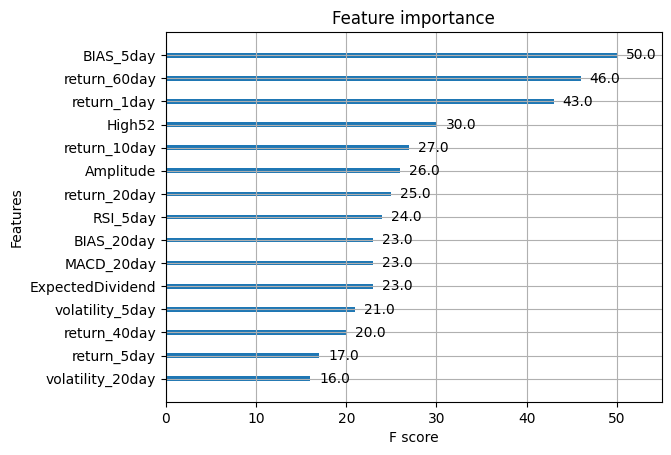

In [44]:
from xgboost import plot_importance
plot_importance(xgb_model_0, max_num_features = 15, importance_type = 'weight')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

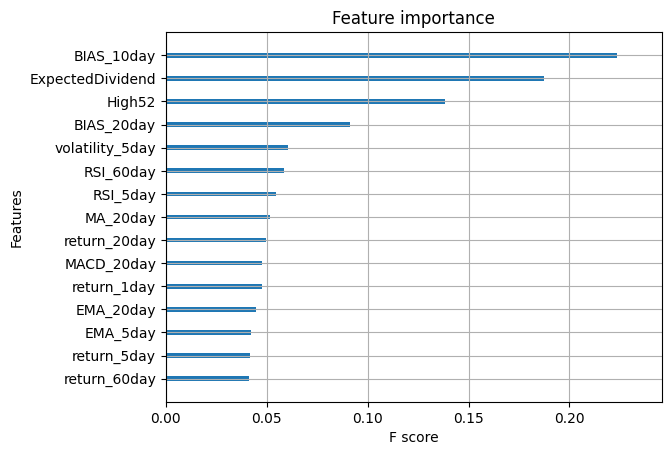

In [46]:
plot_importance(xgb_model_0, max_num_features = 15, importance_type = 'gain', show_values = False)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

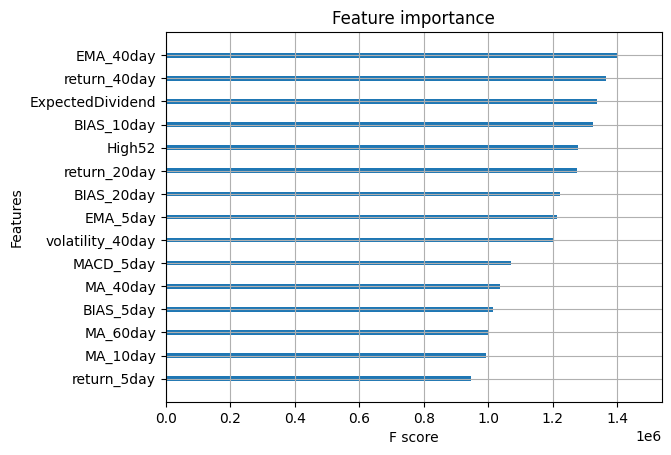

In [47]:
plot_importance(xgb_model_0, max_num_features = 15, importance_type = 'cover', show_values = False)

In [ ]:
def set_rank(df):
    """
    Args:
        df (pd.DataFrame): including predict column
    Returns:
        df (pd.DataFrame): df with Rank
    """
    # sort records to set Rank
    df = df.sort_values("Predict", ascending=False)
    # set Rank starting from 0
    df.loc[:, "Rank"] = np.arange(len(df["Predict"]))
    return df

In [ ]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

In [ ]:
result = old_test_X[["SecuritiesCode"]].copy()
result.loc[:, "Predict"] = lasso_test_pred
result.loc[:, 'Target'] = test_y.values

result = result.sort_values(["Date", "Predict"], ascending=[True, False])
result = result.groupby("Date").apply(set_rank)

print(calc_spread_return_sharpe(result, portfolio_size=200))

result = old_test_X[["SecuritiesCode"]].copy()
result.loc[:, "Predict"] = xgb_gs.predict(X_test)
result.loc[:, 'Target'] = test_y.values

result = result.sort_values(["Date", "Predict"], ascending=[True, False])
result = result.groupby("Date").apply(set_rank)

print(calc_spread_return_sharpe(result, portfolio_size=200))

## Train with PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data_key_features = feature.copy()
data_codes = data_key_features[["SecuritiesCode"]]

pca = PCA(n_components = 'mle')
data_components = pca.fit_transform(feature)

data_components = pd.DataFrame(data_components)
data_components["SecuritiesCode"] = data_codes.values
data_components["Date"] = feature.index.values
data_components.set_index("Date", inplace=True)

sum(pca.explained_variance_ratio_[:2]) # >95% of the variance

data_components = data_components[["SecuritiesCode", 0, 1, 2]] # first 3 components

In [ ]:
df_price

In [ ]:
# generate feature/label
train_X, train_y, test_X, test_y = get_features_and_label(
    df_price, codes, data_components
)

In [ ]:

train_X.loc[:, 'Target'] = train_y
test_X.loc[:, 'Target'] = test_y
train_X.reset_index(inplace = True)
test_X.reset_index(inplace = True)
df_price.reset_index(inplace = True)
train_X = df_price[["Date", "SecuritiesCode"]].merge(train_X, left_on = ['Date', 'SecuritiesCode'],right_on = ['Date', 'SecuritiesCode'], how = 'right')
test_X = df_price[["Date", "SecuritiesCode"]].merge(test_X, left_on = ['Date', 'SecuritiesCode'],right_on = ['Date', 'SecuritiesCode'], how = 'right')
train_X.dropna(inplace = True)
test_X.dropna(inplace = True)

train_y = train_X['Target']
test_y = test_X['Target']
train_X.drop("Target", axis = 1, inplace = True);
test_X.drop("Target", axis = 1, inplace = True);

print("train_X has shape", train_X.shape)
print("train_y has shape", train_y.shape)
print("test_X has shape", test_X.shape)
print("test_y has shape", test_y.shape)

train_X.set_index('Date', inplace = True)
test_X.set_index('Date', inplace = True)

old_test_X = test_X
old_train_X = train_X
feat_cols = list(range(1, 4))
train_X = train_X.iloc[:, feat_cols]
test_X = test_X.iloc[:, feat_cols]

In [ ]:
X_train = train_X.values
X_test = test_X.values
y_train = train_y.values
y_test = test_y.values

In [ ]:
feature_subsets = {
    "012": {"X_train": X_train, "X_test": test_X},
    "01": {"X_train": X_train[:, [0, 1]], "X_test": X_test[:, [0, 1]]},
    "02": {"X_train": X_train[:, [0, 2]], "X_test": X_test[:, [0, 2]]},
    "12": {"X_train": X_train[:, [1, 2]], "X_test": X_test[:, [1, 2]]},
    "0": {"X_train": X_train[:, [0]], "X_test": X_test[:, [0]]},
    "1": {"X_train": X_train[:, [1]], "X_test": X_test[:, [1]]},
    "2": {"X_train": X_train[:, [2]], "X_test": X_test[:, [2]]}
}

feature_subsets_list = ["012", "01", "02", "12", "0", "1", "2"]

In [ ]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV, Lasso
from tqdm import tqdm


results_lasso = dict()
results_xgb = dict()
for subset_key in tqdm(feature_subsets_list):
    X_train = np.reshape(feature_subsets[subset_key]['X_train'],
                         (feature_subsets[subset_key]['X_train'].shape[0],
                          feature_subsets[subset_key]['X_train'].shape[1]))
    X_test = np.reshape(feature_subsets[subset_key]['X_test'],
                         (feature_subsets[subset_key]['X_test'].shape[0],
                          feature_subsets[subset_key]['X_test'].shape[1]))
    
    reg_params = 10**(np.linspace(-8, -0.5, 100))
    num_params = len(reg_params)
    
    model_lasso = LassoCV(n_alphas = num_params, alphas = reg_params,
                      cv = 5, random_state = 0).fit(X_train, y_train)
    lasso_test_pred = model_lasso.predict(X_test)
    
    res_lasso = old_test_X[["SecuritiesCode"]].copy()
    res_lasso.loc[:, "Predict"] = lasso_test_pred
    res_lasso.loc[:, 'Target'] = test_y.values

    res_lasso = res_lasso.sort_values(["Date", "Predict"], ascending=[True, False])
    res_lasso = res_lasso.groupby("Date").apply(set_rank)
    
    results_lasso[subset_key] = calc_spread_return_sharpe(res_lasso, portfolio_size=200)
    
    
    xgb_model = XGBRegressor()

    cv_params = {
        'n_estimators': [100, 200],
        'max_depth': np.linspace(2, 10, 5, dtype = int),
        'learning_rate': 10**(np.linspace(-4, 0, 5))
    }

    xgb_gs = GridSearchCV(estimator = xgb_model, param_grid = cv_params, error_score = 'raise')
    xgb_gs.fit(X_train, y_train)
    
    res_xgb = old_test_X[["SecuritiesCode"]].copy()
    res_xgb.loc[:, "Predict"] = xgb_gs.predict(X_test)
    res_xgb.loc[:, 'Target'] = test_y.values

    res_xgb = res_xgb.sort_values(["Date", "Predict"], ascending=[True, False])
    res_xgb = res_xgb.groupby("Date").apply(set_rank)
    
    results_xgb[subset_key] = calc_spread_return_sharpe(res_xgb, portfolio_size=200)

In [ ]:
results_xgb

In [ ]:
results_lasso